In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rl
from scipy.optimize import fsolve
import numba
from pyswarm import pso

In [2]:
%matplotlib notebook

In [21]:
run = rl.run

@numba.njit(cache=True) 
def solver(struct): 
    sin = np.sin
    cos = np.cos
    sqrt = np.sqrt
    i = 0 
    
    Dt = struct[i].Dt 
    N_steps = struct[i].N_steps 
    N_store = struct[i].N_store 
    N_x = struct[i].N_x
    N_y = struct[i].N_y
    N_outs = 1 
    decimation = struct[i].decimation 
    eye = np.eye(N_x)
    # initialization 
    t = 0.0 
    run(0.0,struct, 1) 
    it_store = 0 
    struct[i]['T'][0] = t 
    struct[i].X[0,:] = struct[i].x[:,0]  
    
    Y = np.zeros((N_store,N_y))
    U = np.zeros((N_store,N_u))
    Z = np.zeros((N_store,N_u))
    
    X[0,:] = struct[i].x[:,0]  
    Y[0,:] = struct[i].y[:,0]  
    U[0,:] = struct[i].u[:,0]  
    
    for it in range(N_steps-1): 
        t += Dt 
 
        perturbations(t,struct) 
        solver = struct[i].solvern 
        if solver == 1: 
            # forward euler solver  
            run(t,struct, 2)  
            struct[i].x[:] += Dt*struct[i].f  
 
        if solver == 2: 
            
            # bacward euler solver
            x_0 = np.copy(struct[i].x[:]) 
            for j in range(struct[i].imax): 
                run(t,struct, 2) 
                run(t,struct, 3) 
                run(t,struct, 10)  
                phi =  x_0 + Dt*struct[i].f - struct[i].x 
                Dx = np.linalg.solve(-(Dt*struct[i].Fx - np.eye(N_x)), phi) 
                struct[i].x[:] += Dx[:] 
                if np.max(np.abs(Dx)) < struct[i].itol: break 
            print(struct[i].f)
 
        if solver == 3: 
            # trapezoidal solver
            run(t,struct, 2) 
            f_0 = np.copy(struct[i].f[:]) 
            x_0 = np.copy(struct[i].x[:]) 
            for j in range(struct[i].imax): 
                run(t,struct, 10)  
                phi =  x_0 + 0.5*Dt*(f_0 + struct[i].f) - struct[i].x 
                Dx = np.linalg.solve(-(0.5*Dt*struct[i].Fx - np.eye(N_x)), phi) 
                struct[i].x[:] += Dx[:] 
                run(t,struct, 2) 
                if np.max(np.abs(Dx)) < struct[i].itol: break 

        if solver == 4: 
            #print(t)
            run(t,struct, 2) 
            run(t,struct, 3) 

            x = np.copy(struct[i].x[:]) 
            y = np.copy(struct[i].y[:]) 
            f = np.copy(struct[i].f[:]) 
            g = np.copy(struct[i].g[:]) 
            
            for iter in range(10):
                run(t,struct, 2) 
                run(t,struct, 3) 
                run(t,struct,10) 
                run(t,struct,11) 
                
                x_i = struct[i].x[:] 
                y_i = struct[i].y[:]  
                f_i = struct[i].f[:] 
                g_i = struct[i].g[:]                 
                F_x_i = struct[i].Fx[:,:]
                F_y_i = struct[i].Fy[:,:] 
                G_x_i = struct[i].Gx[:,:] 
                G_y_i = struct[i].Gy[:,:]                

                A_c_i = np.vstack((np.hstack((eye-0.5*Dt*F_x_i, -0.5*Dt*F_y_i)),
                                   np.hstack((G_x_i,         G_y_i))))
                     
                f_n_i = x_i - x - 0.5*Dt*(f_i+f) 
                
                Dxy_i = np.linalg.solve(-A_c_i,np.vstack((f_n_i,g_i))) 
                
                x_i = x_i + Dxy_i[0:N_x]
                y_i = y_i + Dxy_i[N_x:(N_x+N_y)]

                struct[i].x[:] = x_i
                struct[i].y[:] = y_i
                
                if np.max(np.abs(Dxy_i[:,0]))<1.0e-4:
                    
                    break

            
        # channels 
        if it >= it_store*decimation: 
            struct[i]['T'][it_store+1] = t 
            struct[i].X[it_store+1,:] = struct[i].x[:,0] 
            Y[it_store+1,:] = struct[i].y[:,0]
            it_store += 1 
        
    return struct[i]['T'][:], struct[i].X[:], Y 




In [22]:
@numba.njit(cache=True) 
def perturbations(t,struct): 
    if t>0.01: struct[0].v_t_d=85.59
    if t>0.01: struct[0].v_t_q=-319.4
    if t>0.01: struct[0].v_s_d=0.0
    if t>0.01: struct[0].v_s_q=-326.6
                    

## Initialization

In [49]:
syst =  rl.rl_class()
syst.solvern = 4
syst.decimation = 1

syst.t_end = 0.05
syst.Dt = 0.0001
syst.decimation =1
syst.update()
syst.struct[0].v_t_d = 0.0
syst.struct[0].v_t_q = 0.0
syst.struct[0].v_s_d = 0.0
syst.struct[0].v_s_q = 0.0
#syst.struct[0].H = x_pso[0]
#syst.struct[0].D = x_pso[1]
x0 = np.array([0,0,0,0]).reshape(4,1)
s = fsolve(syst.ini_problem,x0 )
syst.struct[0].x[:,0] = s[0:syst.N_x]
syst.struct[0].y[:,0] = s[syst.N_x:]

In [50]:
T,X,Y = solver(syst.struct)

<IPython.core.display.Javascript object>


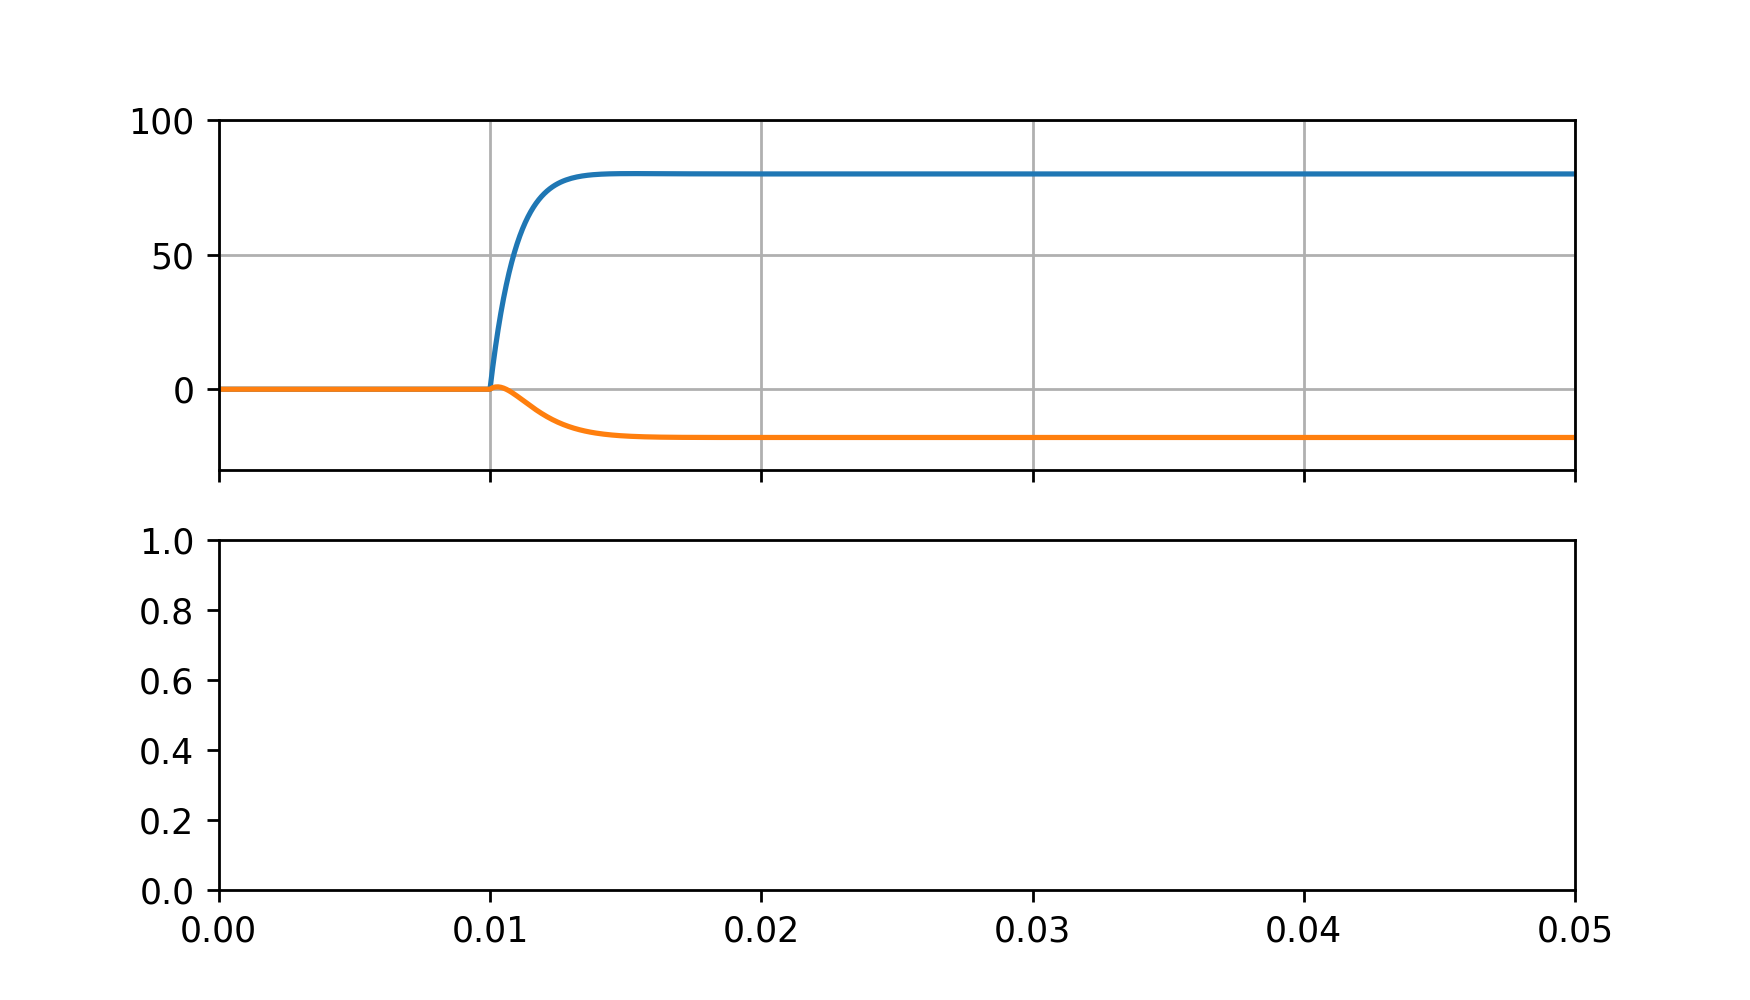

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex = True)


axes[0].plot(T[:-1], X[:-1,0])
axes[0].plot(T[:-1], X[:-1,1])


axes[0].set_ylim([-30,100])
axes[0].set_xlim([0,0.05])
axes[0].grid(True)

In [9]:
#@numba.jit(nopython=True)
def fcost(part):
    syst.struct[0].H = part[0]
    syst.struct[0].D = part[1]
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:]
    T,X,Y = solver(syst.struct)
    P_e = Y[:,0]
    P_e_ref = Y[:,1]
    cost = np.sum((P_e - P_e_ref)**2)
    return cost
    

In [10]:
lb = [1, 1]
ub = [10, 200]
x_pso, fopt = pso(fcost, lb, ub) #, f_ieqcons=con

AttributeError: 'record' object has no attribute 'H'

In [ ]:
x_pso

In [ ]:
axes[0].plot(Times, Omega)
axes[1].plot(Times, P_e)
axes[1].plot(Times, P_e_ref)
#axes[1].plot(x, y_2,'.')

axes[0].set_ylabel('Speeds (p.u.)')
axes[1].set_ylabel('Powers (p.u.)')
axes[1].set_xlabel('Time (s)')
#plt.xticks(rotation=30)  # good when having dates as ticks   
#axes[0].set_ylim([0,12])
axes[0].grid(True)
axes[1].grid(True)

axes[0].set_xlim([0,10])
#axes[1].set_xlim([0,12])

fig.savefig('out.svg', bbox_inches='tight')
fig.savefig('out.pdf', bbox_inches='tight')